In [25]:
import clip
import torch
from fontTools.svgLib import SVGPath
from sympy.printing.latex import tex_greek_dictionary

from AScore.simple_inference import AScorePredictor
from kaggle_evaluation.svg_constraints import SVGConstraints
from sympy.physics.units import temperature
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
import torch
print(clip.__file__)
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count
from multiproc_converter_to_png import convert_svgs_to_pngs_parallel, load_images_parallel
import cairosvg
from IPython.display import display
from AScore import simple_inference as asp
from tqdm.notebook import tqdm
from  kaggle_evaluation import svg_constraints
import seaborn as sns
from datasets import Dataset
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
cur_path = os.getcwd()

/home/student/kuzin/python_project/TextToSvg_MLCUP/.venv/lib/python3.10/site-packages/clip/__init__.py


In [26]:
path_to_train_data = "./AScore/train_data/ava_y_openclip_l14.npy"

In [27]:
y = np.load (path_to_train_data)

### Статистика оценок визуальной эстетичност, на которой обучали AScore predictor

(0    6.574586
 Name: 0.95, dtype: float64,
                    0
 count  255490.000000
 mean        5.383315
 std         0.731305
 min         1.808989
 25%         4.911222
 50%         5.386667
 75%         5.865672
 max         8.600000)

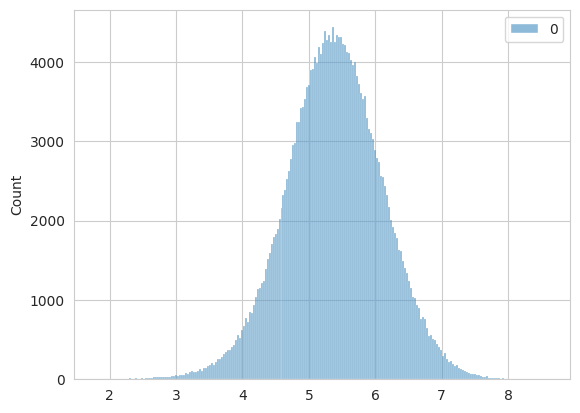

In [28]:
df = pd.DataFrame(y)
sns.histplot(df)
df.quantile(0.95), df.describe()

In [29]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harrabiraouf/scored-svg-11k")

print("Path to dataset files:", path)
eval_dataset = pd.read_csv(os.path.join(path, "svg_dataset_scored_11k.csv"))

Path to dataset files: /home/student/.cache/kagglehub/datasets/harrabiraouf/scored-svg-11k/versions/1


In [30]:
eval_dataset.head(5)

,sentence,best_image_score,svg_code
0,An indigo hexagon bloom glistens with morning ...,0.9801,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."
1,Sharp mountain silhouettes stand amidst a grad...,0.9849,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."
2,A tree composed of interlocking hexagons stand...,0.9965,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."
3,Lavender desert stretching endlessly under moo...,0.9975,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."
4,"A gradient amber, peach, and cobalt sky over e...",0.9997,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r..."


In [31]:
eval_dataset.index, eval_dataset.index.nunique()

(RangeIndex(start=0, stop=11188, step=1), 11188)

#### Filter eval_dataset

In [32]:
print(len(eval_dataset))
eval_dataset = eval_dataset.dropna().reset_index(drop=True)
print(len(eval_dataset))
eval_dataset.index, eval_dataset.index.nunique()

11188
11170


(RangeIndex(start=0, stop=11170, step=1), 11170)

In [33]:
def is_renderable_svg(row, output_path="temp_output.png"):
    try:
        cairosvg.svg2png(bytestring=row['svg_code'].encode('utf-8'), write_to=output_path)
        return True
    except Exception as e:
        print("Ошибка рендеринга SVG:", e)
        return False

eval_dataset["is_valid"] = eval_dataset.apply(is_renderable_svg,axis =1)
valid_eval_dataset = eval_dataset[eval_dataset["is_valid"] == True]

In [34]:
num_processes = cpu_count()
output_folder = "./data/eval_models_png"
print(num_processes)
list(map(lambda index: os.path.join(output_folder, f"{index}.png"), [1,2,3] ))

32


['./data/eval_models_png/1.png',
 './data/eval_models_png/2.png',
 './data/eval_models_png/3.png']

#### Конвертируем в PNG и запишем в память все SVG из датасета

In [35]:
for_path_columns = []
for i in tqdm(range(0, len(eval_dataset), num_processes), 
              total=len(range(0, len(eval_dataset), num_processes)), 
              desc="Processing batches"):
    start_i = i
    end_i = i+ num_processes
    batch = eval_dataset["svg_code"][start_i:end_i].to_dict()
    for_path_columns+=  list(map(lambda index: os.path.join(output_folder, f"{index}.png"),np.arange(start_i,end_i) ))
    res = convert_svgs_to_pngs_parallel(batch,output_folder,num_processes)
    print(sum(list(res.values())))
    assert sum(list(res.values())) == len(batch)

Processing batches:   0%|          | 0/350 [00:00<?, ?it/s]

Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 процессах...
32
Запуск обработки на 32 пр

In [36]:
import os

def collect_numbers_from_filenames(folder):
    filenames = os.listdir(folder)
    numbers = []
    for filename in filenames:
        if filename.endswith(".png"):
            try:
                number = int(filename[:-4])
                numbers.append(number)
            except ValueError:
                pass
    return sorted(numbers)
numbers_list = collect_numbers_from_filenames(output_folder)

from collections import Counter
counts = Counter(numbers_list)
duplicates = [number for number, count in counts.items() if count > 1]
print(len(numbers_list))
print("Повторяющиеся числа:", duplicates)
assert len(numbers_list) == len(eval_dataset)
assert len(duplicates) ==0
max(numbers_list)

11170
Повторяющиеся числа: []


11169

In [37]:
for_path_columns = for_path_columns[:len(eval_dataset)]
for_path_columns[-3:], len(eval_dataset)

(['./data/eval_models_png/11167.png',
  './data/eval_models_png/11168.png',
  './data/eval_models_png/11169.png'],
 11170)

#### Сохраним в PNG 

In [38]:
eval_dataset["path_to_png"] = for_path_columns
eval_dataset.to_csv("./data/svg_eval_dataset.csv")
eval_dataset.head(5)

,sentence,best_image_score,svg_code,path_to_png
0,An indigo hexagon bloom glistens with morning ...,0.9801,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r...",./data/eval_models_png/0.png
1,Sharp mountain silhouettes stand amidst a grad...,0.9849,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r...",./data/eval_models_png/1.png
2,A tree composed of interlocking hexagons stand...,0.9965,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r...",./data/eval_models_png/2.png
3,Lavender desert stretching endlessly under moo...,0.9975,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r...",./data/eval_models_png/3.png
4,"A gradient amber, peach, and cobalt sky over e...",0.9997,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-r...",./data/eval_models_png/4.png


In [39]:
eval_dataset = pd.read_csv("./data/svg_eval_dataset.csv")

### Посмотрим, какие скоры эстетичности выдаёт предиктор на датасете

Ключ: 0


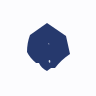

Ключ: 1


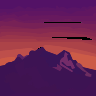

Ключ: 2


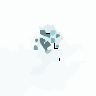

Ключ: 3


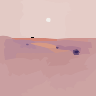

Ключ: 4


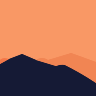

In [40]:
for_path_columns = []
num_processes = 5
for i in range(0,5,num_processes):
    start_i = i
    end_i = i+ num_processes
    batch = eval_dataset["path_to_png"][start_i:end_i].to_dict()
    images = load_images_parallel(batch, num_processes)

    for key, img in images.items():
        print(f"Ключ: {key}")
        display(img)
    

In [41]:
MLP_name = "AScore/sac+logos+ava1-l14-linearMSE.pth"
full_path= os.path.join(cur_path, MLP_name)
score_predictor = asp.AScorePredictor(full_path)
batch  = list(images.values())
res  = score_predictor.get_score(batch)
res

tensor([[3.8287],
        [4.9325],
        [3.5909],
        [4.8256],
        [4.6752]], device='cuda:0')

#### Посчитаем скор на всём датасете

In [42]:
for_original_score_column = []
num_processes = 32
for i in tqdm(range(0, len(eval_dataset), num_processes), 
              total=len(range(0, len(eval_dataset), num_processes)), 
              desc="Processing batches"):
    start_i = i
    end_i = i+ num_processes
    batch = eval_dataset["path_to_png"][start_i:end_i].to_dict()
    images = load_images_parallel(batch, num_processes)
    batch_scores = score_predictor.get_score(list(images.values())).detach().cpu().numpy()
    for_original_score_column.append(batch_scores)
    

Processing batches:   0%|          | 0/350 [00:00<?, ?it/s]

In [43]:
len(for_original_score_column)
res = np.vstack(for_original_score_column)
len(res)
eval_dataset["original_AScore"] = res
eval_dataset.to_csv("./data/svg_eval_dataset.csv", index=False)
eval_dataset.head(5)

,Unnamed: 0,sentence,best_image_score,svg_code,path_to_png,original_AScore
0,0,An indigo hexagon bloom glistens with morning dew.,0.9801,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-rule=""evenodd"" image-rendering=""optimizeQuality"" shape-rendering=""geometricPrecision"" text-rendering=""geometricPrecision"" viewBox=""0 0 96 96""><path fill=""#fcfcfe"" d=""M0 0h96v96H0z""/><path fill=""#26396d"" d=""m47 23 19 13 4 18q-9 6-15 14h-4l-4 3q-6-3-8-8h-3q-6-5-9-11 0-9 3-17z""/><path fill=""#949db5"" d=""M48 43q2 0 1 2z""/><path fill=""#d7dde6"" d=""M49 60q2 0 1 3-2-1-1-3""/></svg>",./data/eval_models_png/0.png,3.827508
1,1,Sharp mountain silhouettes stand amidst a gradient violet to amber sky.,0.9849,"<svg xmlns=""http://www.w3.org/2000/svg"" clip-rule=""evenodd"" image-rendering=""optimizeQuality"" shape-rendering=""geometricPrecision"" text-rendering=""geometricPrecision"" viewBox=""0 0 96 96""><path fill=""#531266"" d=""M0 0h96v6l-3 1q-3-2-6 1-4-3-6 1-7-3-14 0-4-3-8-1-3-5-3 1-10-3-21 0l-7-2-3 2-6-3-6 3H0z""/><path fill=""#5a1564"" d=""m93 7-6 3q-2-2-2 0l1 1h-9l-6 3-9-3H28q-11 0-21 3l-1-2-6 1V9h13l6-3 6 3 3-2 7 2q11-3 21 0 0-6 3-1 4-2 8 1 7-3 14 0 2-4 6-1 3-3 6-1""/><path fill=""#601661"" d=""M96 6v7q-3 0-3 3-3-2-6 1L0 16v-3l6-1 1 2q10-3 21-3h34l9 3 6-3h9l-1-1q0-2 2 0l6-3z""/><path fill=""#67195e"" d=""M96 13v8H73l-3-2-20 2-2-2-25 2-11-3q-6 0-11 3H0v-5q2 1 3-1 6 1 11-1l4 3 9-3 2 2 27-1 5 1h32q0-3 3-3""/><path fill=""#6d1c5b"" d=""M96 21v3H84q-2-3-5-2-27-1-52 1-7 0-13-3-7 3-13 1 5-3 11-3l11 3 25-2 2 2 20-2 3 2z""/><path fill=""#772156"" d=""M96 24v6l-2 1q-7-3-14-3l-7 1-3-2q-18-1-36 2L6 26q-3-1-6 1v-6h1q6 2 13-1 6 3 13 3z""/><path fill=""#802652"" d=""M96 30v3l-47-4H0v-2q3-2 6-1l28 3q18-3 36-2l3 2 7-1q7 0 14 3z""/><path fill=""#872950"" d=""M0 29h49l47 4v4q-22-5-44-5l-12 2q-19-3-39-2l-1 3z""/><path fill=""#902f4d"" d=""M96 37v4q-4-3-9-4H43L8 35l-8 2v-2l1-3q20-1 39 2l12-2q22 0 44 5""/><path fill=""#99354a"" d=""M96 41v2l-18-3H51l-13 1-3-2H0v-2l8-2z""/><path fill=""#a23b48"" d=""M0 39h35l3 2 13-1h27l18 3v3l-14-4-14 2-20-2H0z""/><path fill=""#ac4348"" d=""M0 42h82l14 4v8q-25-7-50-9-2 0-3 2l-2-1q-4 2-6 5-2-3-5-3L0 51z""/><path fill=""#bb4e4a"" d=""M96 54v3l-10-2-2 1-14-3-6-3-7 5-11-4-3-4q1-2 3-2 25 2 50 9""/><path fill=""#be4f4b"" d=""M35 51q-6-2-6 4-3 0-5 2l-4-3q-3 0-3 3l-2 3v-3q-9 0-15 2v-8l30-3q3 0 5 3""/><path fill=""#5c2362"" d=""m29 55-7 5q-2-4-5-3 0-3 3-3l4 3q2-2 5-2""/><path fill=""#3d1353"" d=""m43 47 3 4h-3l-4 6h6q0 6 1 1h3q-6 3 0 6l-1 2 4 1 8 4 2-3-2-2v-1l12 7 1-1q3 4 9 3l-1-1 2-2 4 2q-3 1-1 3l6 1q-3-1 0-2-6-3-10-8h1l13 3v12l-4-2q-3 8-11 11l-10-3q-4 1-4 4l-3 1 1 1-10 1v-2q2-2 6-1-1-4-4-3l-2-5-6 3q0-6-5-6l-5-8-3-7-12 3v-8l-6 3-7-2 4-2 2-3q3-1 5 3l7-5q0-6 6-4z""/><path fill=""#391456"" d=""m70 53 3 7h3l2 3q-3 0-1 3l6 5-2 2 1 1q-6 1-9-3l-11-7q-2-2 1-2l4 4h4l1 3 3-1-3-6q-1-3-4-1l-1-5q0-2 2-1l-4-3-1 5q-5 2-4 8v1l-3-2v3h-5l-4-1 1-2q-6-3 0-6h-3q-1 5-1-1h-6l4-6h3l11 4 7-5z""/><path fill=""#cc5b47"" d=""M96 57v13l-13-3q-2-4-5-4l-2-3h-3l-3-7 2-1 14 3z""/><path fill=""#cc5946"" d=""m15 60-4 2q-4 0-6 3l-5 1v-7q6-2 15-2z""/><path fill=""#742c69"" d=""m73 71-1 1-12-7q-1-6 4-8l1-5 4 3q-2-1-2 1l1 5q3-2 4 1l3 6-3 1-1-3h-4l-4-4q-3 0-1 2z""/><path fill=""#401353"" d=""m49 87-4-1-7 3-5-3q1-3-1-4v3q-3-1-4 1v-4q4-1 4-6l-4-1q1-2-1-2l-1 2q-4-1-5 3l-3-4-3-7q0-4 3-3l6-3v8l12-3 3 7 5 8q5 0 5 6""/><path fill=""#3c1252"" d=""m11 62 7 2q-3-1-3 3l3 7-5-2-8 4 1 4-2 1q2 3 5 1l2 7 6 4-10 3H0V66l5-1q2-3 6-3""/><path fill=""#662461"" d=""m60 66 2 2-2 3-8-4h5v-3z""/><path fill=""#6d2c60"" d=""M78 63q3 0 5 4h-1q4 5 10 8-3 1 0 2l-6-1q-2-2 1-3l-4-2-6-5q-2-3 1-3""/><path fill=""#3f1350"" d=""m18 74 3 4q1-4 5-3l1-2q2 0 1 2l4 1q0 5-4 6v4q1-2 4-1v-3q2 1 1 4l5 3 7-3 4 1 6-3 2 5q3-1 4 3-4-1-6 1H17l-6-4-2-7q-3 2-5-1l2-1-1-4 8-4z""/><path fill=""#401253"" d=""M96 82v14H7l10-3h38v2l10-1-1-1 3-1q0-3 4-4l10 3q8-3 11-11z""/></svg>",./data/eval_models_png/1.png,4.932559
2,2,A tree composed of interlocking hexagons stands amidst drifting mist.,0.9965,"<svg xmlns=""http://www

#### Генерируем SVG сами из датасета

In [44]:
model_name = "Qwen/Qwen3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda",
    attn_implementation="flash_attention_2" #поменять
)
model.bfloat16()

tokenizer_config.json:   0%|          | 0.00/9.73k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 4096)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (up_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (down_proj): Linear(in_features=12288, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): 

In [45]:
tokenizer.padding_side  = 'left'

In [46]:
optional_prompt = "The SVG scene should be of the following dimensions 256*256. First, think about the scene, about the objects on the stage and their characteristics. Make sure that all tags are closed and the svg is correct! Answer is only SVG without comments!"

In [47]:
def get_sample(row):
    user_content_prompt = f"Generate SVG image from description <{row.sentence[:-1]}>. {optional_prompt}"
    return [{"role": "user", "content": user_content_prompt}]


eval_dataset["eval_data"] = eval_dataset.apply(get_sample, axis=1)

In [48]:
eval_dataset.eval_data[1:3]

1    [{'role': 'user', 'content': 'Generate SVG image from description <Sharp mountain silhouettes stand amidst a gradient violet to amber sky>. The SVG scene should be of the following dimensions 256*256. First, think about the scene, about the objects on the stage and their characteristics. Make sure that all tags are closed and the svg is correct! Answer is only SVG without comments!'}]
2      [{'role': 'user', 'content': 'Generate SVG image from description <A tree composed of interlocking hexagons stands amidst drifting mist>. The SVG scene should be of the following dimensions 256*256. First, think about the scene, about the objects on the stage and their characteristics. Make sure that all tags are closed and the svg is correct! Answer is only SVG without comments!'}]
Name: eval_data, dtype: object

In [49]:
dataset = Dataset.from_dict({"query": list(eval_dataset["eval_data"])})

In [50]:
dataset[1]['query']

[{'content': 'Generate SVG image from description <Sharp mountain silhouettes stand amidst a gradient violet to amber sky>. The SVG scene should be of the following dimensions 256*256. First, think about the scene, about the objects on the stage and their characteristics. Make sure that all tags are closed and the svg is correct! Answer is only SVG without comments!',
  'role': 'user'}]

In [51]:
dataset = dataset.map(lambda x: {"formatted_query": tokenizer.apply_chat_template(x["query"], tokenize=False, add_generation_prompt=True, enable_thinking=False)}, remove_columns=["query"])

Map:   0%|          | 0/11170 [00:00<?, ? examples/s]

In [52]:
print(dataset['formatted_query'][0])

<|im_start|>user
Generate SVG image from description <An indigo hexagon bloom glistens with morning dew>. The SVG scene should be of the following dimensions 256*256. First, think about the scene, about the objects on the stage and their characteristics. Make sure that all tags are closed and the svg is correct! Answer is only SVG without comments!<|im_end|>
<|im_start|>assistant
<think>

</think>




In [53]:
def preprocess_function(examples):
    return tokenizer(examples["formatted_query"], padding=False, truncation=False)
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=["formatted_query"]
)

Map (num_proc=4):   0%|          | 0/11170 [00:00<?, ? examples/s]

In [54]:
len(tokenized_dataset[0]['input_ids']), len(tokenized_dataset[1]['input_ids'])

(86, 87)

In [55]:
print(tokenizer.batch_decode(tokenized_dataset[0]['input_ids'], skip_special_tokens=True))

['', 'user', '\n', 'Generate', ' SVG', ' image', ' from', ' description', ' <', 'An', ' ind', 'igo', ' hex', 'agon', ' bloom', ' g', 'list', 'ens', ' with', ' morning', ' dew', '>.', ' The', ' SVG', ' scene', ' should', ' be', ' of', ' the', ' following', ' dimensions', ' ', '2', '5', '6', '*', '2', '5', '6', '.', ' First', ',', ' think', ' about', ' the', ' scene', ',', ' about', ' the', ' objects', ' on', ' the', ' stage', ' and', ' their', ' characteristics', '.', ' Make', ' sure', ' that', ' all', ' tags', ' are', ' closed', ' and', ' the', ' svg', ' is', ' correct', '!', ' Answer', ' is', ' only', ' SVG', ' without', ' comments', '!', '', '\n', '', 'assistant', '\n', '<think>', '\n\n', '</think>', '\n\n']


In [56]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Создаем DataLoader
dataloader = DataLoader(
    tokenized_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=data_collator,
)

In [57]:
model.eval()

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 4096)
    (layers): ModuleList(
      (0-35): 36 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (up_proj): Linear(in_features=4096, out_features=12288, bias=False)
          (down_proj): Linear(in_features=12288, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): 

In [ ]:
once_checked= False
svg_answers = []
for batch in tqdm(dataloader, desc="Генерация SVG"):
    batch = {k: v.to("cuda") for k, v in batch.items()}
    with torch.no_grad():
        print()
        outputs = model.generate(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            max_new_tokens=1000
        )
        input_ids = batch["input_ids"].cpu()
        outputs =  outputs.cpu()
        batch_output_ids = [
            outputs[i][len(input_ids[i]):].tolist()
            for i in range(input_ids.size(0))
        ]
    decoded_responses= tokenizer.batch_decode(batch_output_ids, skip_special_tokens=True)
    if once_checked == False:
        once_checked = True
        print("simple check")
        print(decoded_responses)
    svg_answers+=decoded_responses

Генерация SVG:   0%|          | 0/350 [00:00<?, ?it/s]


simple check
['<svg width="256" height="256" viewBox="0 0 256 256" xmlns="http://www.w3.org/2000/svg">\n  <defs>\n    <linearGradient id="grad1" x1="0" y1="0" x2="1" y2="1">\n      <stop offset="0%" style="stop-color:#4b0082;stop-opacity:1" />\n      <stop offset="100%" style="stop-color:#000080;stop-opacity:1" />\n    </linearGradient>\n    <radialGradient id="dew" cx="50%" cy="50%" r="50%" fx="50%" fy="50%">\n      <stop offset="0%" style="stop-color:#ffffff;stop-opacity:0.8" />\n      <stop offset="100%" style="stop-color:#000000;stop-opacity:0" />\n    </radialGradient>\n  </defs>\n  <polygon points="128,20 176,68 224,68 176,116 128,116 80,68 32,68 80,116 128,164 176,116 224,116 176,164 128,204 80,164 32,164 80,116" fill="url(#grad1)" />\n  <circle cx="128" cy="128" r="4" fill="url(#dew)" />\n  <circle cx="136" cy="128" r="4" fill="url(#dew)" />\n  <circle cx="144" cy="128" r="4" fill="url(#dew)" />\n  <circle cx="112" cy="128" r="4" fill="url(#dew)" />\n  <circle cx="104" cy="128

In [24]:
dir_path_for_res = os.path.join(cur_path, model_name)
print(dir_path_for_res)
file_path = os.path.join(dir_path_for_res, "outputs_model.csv")
os.makedirs(os.path.dirname(file_path), exist_ok=True)
temp = pd.DataFrame(svg_answers)
temp.to_csv(file_path,index = False)

'/home/student/kuzin/python_project/TextToSvg_MLCUP/Qwen/Qwen3-8B'

In [3]:
temp = pd.read_csv(file_path)
temp.head(2)

,0
0,"<svg width=""256"" height=""256"" xmlns=""http://ww..."
1,"<svg width=""256"" height=""256"" viewBox=""0 0 256..."


### Визуальная оценка, красный круг означает, что SVG-код, выданный моделью, не валиден, поэтому отрисовывается заглушка

#### P.S проблема чаще всего в том, что не хватило токенов, чтобы догенерить изображение. 

In [4]:
from multiproc_converter_to_png import convert_svgs_to_pngs_parallel_in_memory
def plug():
    pass

In [ ]:
for_path_columns = []
num_processes = 32
for i in range(0,32,num_processes):
    start_i = i
    end_i = i+ num_processes
    batch_gereric = temp["0"][start_i:end_i].to_dict()
    generated_images_and_flags = convert_svgs_to_pngs_parallel_in_memory(list(batch_gereric.values(),), num_processes)
    batch = eval_dataset["path_to_png"][start_i:end_i].to_dict()
    original_images = load_images_parallel(batch, num_processes)
    for i in range(len(batch)):
        print(eval_dataset.loc[start_i +i, ['sentence']])
        orig_image = original_images[i]
        generated_image, flag = generated_images_and_flags[i]
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(orig_image)
        axes[0].set_title("Orginal")
        axes[0].axis("off")
        
        axes[1].imshow(generated_image)
        axes[1].set_title("Generated")
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.show()

### Оценка эстетичности в метриках

In [21]:
MLP_name = "AScore/sac+logos+ava1-l14-linearMSE.pth"
full_path = os.path.join(cur_path, MLP_name)
score_predictor = asp.AScorePredictor(full_path)
for_generated_score_column = []
for_cancel_flag=column = []
num_processes = 32
for i in tqdm(range(0, len(temp), num_processes),
              total=len(range(0, len(temp), num_processes)),
              desc="Processing batches"):
    start_i = i
    end_i = i + num_processes
    batch_gereric = temp["0"][start_i:end_i].to_dict()
    generated_images_and_flags = convert_svgs_to_pngs_parallel_in_memory(list(batch_gereric.values()), num_processes)
    images = list(map(lambda t: t[0], generated_images_and_flags))
    flags = list(map(lambda t: t[1], generated_images_and_flags))
    batch_scores = score_predictor.get_score(images).detach().cpu().numpy()
    for_generated_score_column.append(batch_scores)
    for_cancel_flag+=flags


Processing batches:   0%|          | 0/19 [00:00<?, ?it/s]

Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...
Запуск обработки на 32 процессах...


In [ ]:
len(for_generated_score_column)
res = np.vstack(for_generated_score_column)
len(res)
eval_dataset["generic_AScore"] = res
eval_dataset["cancel_flag"] = for_cancel_flag
eval_dataset.to_csv(os.path.join(dir_path_for_res,"eval_results.csv"), index=False)
eval_dataset.head(5)